In [41]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

In [42]:
def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df

df = load_data("train.csv")

In [43]:
def clean(df):


    df = df.drop(df[df['station'].isin(["leicestershire",'humberside', 'lancashire','metropolitan','west-midlands'])].index)
    
    
    # Fill in missing Latitude and Longitude values based on station averages
    #df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].fillna(value=df.groupby('station')[['Latitude', 'Longitude']].transform('mean'))
    
    df['Part of a policing operation'] = df['Part of a policing operation'].fillna(False)
    df['Part of a policing operation'] = df['Part of a policing operation'].astype(bool)

    df['Outcome linked to object of search'] = df['Outcome linked to object of search'].fillna(False)


    df['Legislation'] = df['Legislation'].fillna('unknown')
    
    df.loc[df['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']

    # create a new column called "success" with 1 if the outcome is in the list of successful outcomes, 0 otherwise
    df['success'] = df.apply(lambda x: True if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else False, axis=1)


    #df=df.dropna()
    return df

df_new = clean(df)

In [44]:
df_new

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,success
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,False,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire,False
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,False,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire,False
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,False,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire,False
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,False,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire,False
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,False,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856605,ee337b9a-12ad-45fd-8c60-49091a0f4ab8,Person and Vehicle search,2020-04-30T15:10:00+00:00,False,54.965502,-1.604609,Male,18-24,White - Any other White background,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,northumbria,False
856606,5973a004-e579-4dd2-bc26-71ab5717f87a,Person and Vehicle search,2020-04-30T15:10:00+00:00,False,54.965502,-1.604609,Male,25-34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,northumbria,False
856607,ad053a34-364e-4d24-8f5c-9734ab5fdbe0,Person and Vehicle search,2020-04-30T17:00:00+00:00,False,54.966266,-1.453704,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,True,False,northumbria,True
856608,8736e5ec-7ca2-420b-ad56-4dd88d27fe6e,Person search,2020-04-30T17:35:00+00:00,False,54.971596,-1.636589,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,northumbria,True


In [45]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Date'] = pd.to_datetime(X['Date'])
        X['Hour'] = X['Date'].dt.hour
        X['Month'] = X['Date'].dt.month
        X['Day'] = X['Date'].dt.day
        X['DayOfWeek'] = X['Date'].dt.weekday
        X=X.drop(columns = "Date", axis=1)
        
        return X[['Hour','Month', 'Day','DayOfWeek']]

    def get_feature_names_out(self):
        return [('Date', 'Hour'), ('Date', 'Month'), ('Date', 'Day'),('Date', 'DayOfWeek')]


In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

features = ["observation_id",'Type','Part of a policing operation', 'Latitude', 'Longitude','Legislation', 'Object of search','Date',"Age range","Gender",'station','Officer-defined ethnicity']
#features = ["observation_id",'Type','Part of a policing operation', 'Latitude', 'Longitude','Legislation', 'Object of search','Date']
target = 'success'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_new[features], df_new[target], test_size=0.33, random_state=42)


categorical_columns = ['Legislation', 'Object of search','Part of a policing operation',"Age range","Gender",'Officer-defined ethnicity','station']
#numeric_columns = ['Latitude', 'Longitude']
feat_columns = ['Date']


# Define the under-sampler
#under_sampler = RandomUnderSampler(sampling_strategy=0.75, random_state=42)

# Fit and transform the training data
#X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)



numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
    
])

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])

preprocessor = ColumnTransformer(
    transformers=[
       ('date_transformer', DateTransformer(), feat_columns),
        #("date", make_pipeline(DateTransformer(), StandardScaler()), feat_columns),
        #('numeric_transformers', numeric_transformer, numeric_columns),
        #('numeric_transformers2', numeric_transformer, feat_columns),
        ('categorical_transformers', categorical_transformer, categorical_columns),
    ])


preprocessor.fit(X_train_resampled)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               #('classifier', RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1))
                               #('classifier',LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', random_state=42, solver='lbfgs', max_iter=500, n_jobs=-1))
                               #("classifier" , LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,random_state=42, ))
                               #("classifier", RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, class_weight="balanced", random_state=42, n_jobs=-1))
                               ("classifer",LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=42))
                               #("classifer",GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=42))
                               #("Classifier",RandomForestClassifier(n_jobs=-1,random_state=42))
                               #("Classifier", LogisticRegression(n_jobs=-1))
                               #("classifier", LGBMClassifier(n_estimators=200, max_depth = 7,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1))

])

# Fit model on training data
pipeline.fit(X_train, y_train)

#pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Get predicted probabilities for positive class

threshold = 0.35
y_pred = (y_pred_proba > threshold).astype(int)


# Print f1 score, recall score, and precision score
print('F1 score:', f1_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred))
print('Precision score:', precision_score(y_test, y_pred))

F1 score: 0.35191500971999584
Recall score: 0.8985500936125745
Precision score: 0.21880466935971246


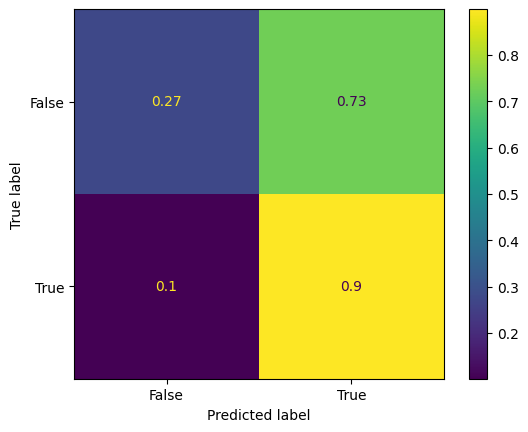

In [48]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()
plt.savefig("confusion_matrix.jpg", bbox_inches='tight')

In [49]:
from sklearn.metrics import confusion_matrix

best_threshold = 0
best_false_false_rate = 0
recall_range = (0.90, 1)

for threshold in range(0, 100):
    threshold /= 100
    y_pred = (y_pred_proba > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_false_rate = tn / (tn + fp)
    recall = tp / (tp + fn)
    if false_false_rate > best_false_false_rate and recall_range[0] <= recall <= recall_range[1]:
        best_threshold = threshold
        best_false_false_rate = false_false_rate

print(f'Best threshold: {best_threshold}')

Best threshold: 0.34


In [50]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Age range', max_diff=0.05):
    """
    Verifies that no department has discrimination in between protected age ranges
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_departments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_departments



In [51]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

classifiers = [
    LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=42),
    #LogisticRegression(C=1, n_jobs=-1, random_state=42),
    #RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1),
    #RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, class_weight="balanced", random_state=42, n_jobs=-1),
    #GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=42),
    #LGBMClassifier(n_estimators=100, max_depth = 7,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1),
    #LGBMClassifier(n_estimators=200, max_depth = 7,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1),
    LGBMClassifier(n_estimators=100, max_depth = 3,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1),
    
]


for classifier in classifiers:
    print("\n\new")
    print(classifier)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    # Fit model on training data
    #pipeline.fit(X_train, y_train)
    #pipeline.fit(X_train, y_train)
    pipeline.fit(X_train, y_train)


    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Get predicted probabilities for positive class
    

    l =[0.90]
    
    for s in l:
    
    
        best_threshold = 0
        best_false_false_rate = 0
        recall_range = (s, 1)

        for threshold in range(0, 100):
            threshold /= 100
            y_pred = (y_pred_proba > threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            false_false_rate = tn / (tn + fp)
            recall = tp / (tp + fn)
            if false_false_rate > best_false_false_rate and recall_range[0] <= recall <= recall_range[1]:
                best_threshold = threshold
                best_false_false_rate = false_false_rate

        threshold = best_threshold
        #threshold= 0.47
        print("threshold",threshold)
        y_pred = (y_pred_proba > threshold).astype(int)


        print('F1 score:', f1_score(y_test, y_pred))
        print('Recall score:', recall_score(y_test, y_pred))
        print('Precision score:', precision_score(y_test, y_pred))
        print("ROC score:", roc_auc_score(y_test, y_pred))

        print("\n\nGender")
        is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
            X_test, y_test, y_pred, sensitive_column='Gender')

        if not is_satisfied:
            print("Requirement failed 😢")
            print("Num problematic departments: {}".format(len(problematic_departments)))
            print("Num good departments: {}".format(len(good_deparments)))
            g_a= np.mean([p[1] for p in problematic_departments])
            print("avg diff:", np.mean([p[1] for p in problematic_departments]))


        print("\nEthnicity")
        is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
            X_test, y_test, y_pred, sensitive_column='Officer-defined ethnicity')

        if not is_satisfied:
            print("Requirement failed 😢")
            print("Num problematic departments: {}".format(len(problematic_departments)))
            print("Num good departments: {}".format(len(good_deparments)))
            e_a = np.mean([p[1] for p in problematic_departments])
            print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        else:
            print("Requirement satisfied! 🚀")


        print("\n age ")
        is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
            X_test, y_test, y_pred)

        if not is_satisfied:
            print("Requirement failed 😢")
            print("Num problematic departments: {}".format(len(problematic_departments)))
            print("Num good departments: {}".format(len(good_deparments)))
            a_a = np.mean([p[1] for p in problematic_departments])
            print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        else:
            print("Requirement satisfied! 🚀")

        cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_, normalize='true')
        print("\n")
        print(cm)
        print((a_a+g_a+e_a)/3)

        print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))
        print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')



ew
LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=42)
threshold 0.34
F1 score: 0.3496909910060797
Recall score: 0.9090869508425131
Precision score: 0.21648159092558608
ROC score: 0.5816112633323466


Gender
Requirement failed 😢
Num problematic departments: 21
Num good departments: 15
avg diff: 0.17463505939587018

Ethnicity
Requirement failed 😢
Num problematic departments: 28
Num good departments: 8
avg diff: 0.20566841726581503

 age 
Requirement failed 😢
Num problematic departments: 35
Num good departments: 1
avg diff: 0.19022081470934213


[[0.25413558 0.74586442]
 [0.09091305 0.90908695]]
0.19017476379034245
Departments analysed: 36
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


ew
LGBMClassifier(class_weight='balanced', max_depth=3, random_state=42)
threshold 0.38
F1 score: 0.35439850608802925
Recall score: 0.913092698219184
Precision sco

/home/francisco/.virtualenvs/slu01/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/francisco/.virtualenvs/slu01/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_